## Bank Note Authentication - PySpark - StreamLit

**Description of the data:**

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.

**Class 0 is for Authentic notes and Class 1 is for Fake notes**

**Objective:**
**To build a classification model that can predict the authenticity of banknotes and deploy it using streamlit library**

In [1]:
# Install PySpark
!pip -q install pyspark flasgger

### Importing initial libraries

In [2]:
import plotly.express as px
from pyspark.sql import SparkSession, functions as f
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Data Exploration

**Creating a Spark Session**

In [3]:
spark = SparkSession.builder.master('local[3]').appName('BankNoteAuthentication').getOrCreate()

**Reading the CSV file**

In [4]:
df = spark.read.csv('../input/bank-note-authentication-uci-data/BankNote_Authentication.csv',header=True,inferSchema=True)

**Let's print the first few elements in the dataset**

In [5]:
df.show(5)

+--------+--------+--------+--------+-----+
|variance|skewness|curtosis| entropy|class|
+--------+--------+--------+--------+-----+
|  3.6216|  8.6661| -2.8073|-0.44699|    0|
|  4.5459|  8.1674| -2.4586| -1.4621|    0|
|   3.866| -2.6383|  1.9242| 0.10645|    0|
|  3.4566|  9.5228| -4.0112| -3.5944|    0|
| 0.32924| -4.4552|  4.5718| -0.9888|    0|
+--------+--------+--------+--------+-----+
only showing top 5 rows



**As shown above, we have 5 columns of which the last column is the target class**

**Let's print the schema of the data**

In [6]:
df.printSchema()

root
 |-- variance: double (nullable = true)
 |-- skewness: double (nullable = true)
 |-- curtosis: double (nullable = true)
 |-- entropy: double (nullable = true)
 |-- class: integer (nullable = true)



**Spark has correctly inferred the schema for this data. Hence type casting is not required.**

**Searching for null values in df**

In [7]:
df.select([f.sum(f.isnan(f.col(c)).cast('int')).alias(f'null_{c}') for c in df.columns]).show()

+-------------+-------------+-------------+------------+----------+
|null_variance|null_skewness|null_curtosis|null_entropy|null_class|
+-------------+-------------+-------------+------------+----------+
|            0|            0|            0|           0|         0|
+-------------+-------------+-------------+------------+----------+



**The dataset is very clean and has no null values present.**

**Let's print the shape of the dataset**

In [8]:
print("(",df.count(),",",len(df.columns),")")

( 1372 , 5 )


**Let's have a look at the countplot of the classes available. As of May 26 2021, PySpark doesn't have any plotting functionality. We shall do this using other Python plotting libraries.**

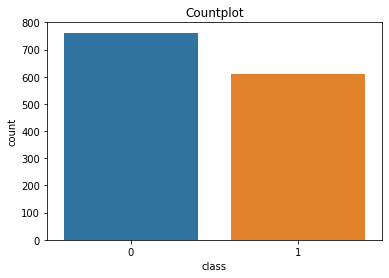

In [9]:
data = df.select('class').toPandas()
sns.countplot(data=data,x='class')
_=plt.title("Countplot")

**Let's separate each feature by class and visualize their distribution.**

**Both the classes have nearly equal count. Hence, the dataset has good balance**

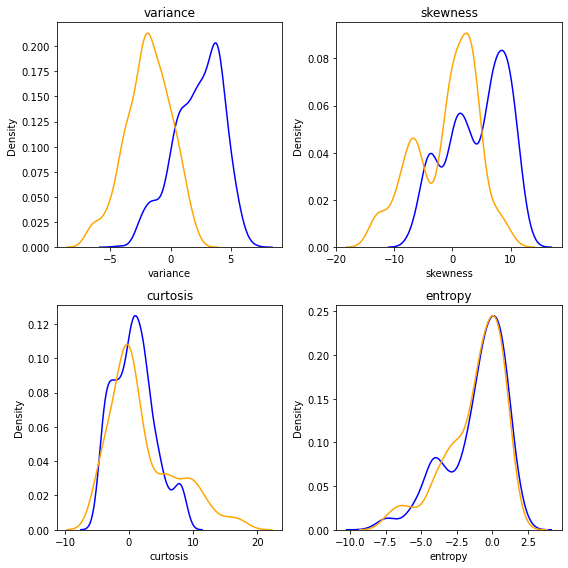

In [10]:
#Seperating the dataset according to class for easy plotting
data_0=df.where(f.col("class")==0)
data_1=df.where(f.col("class")==1)

#KDE plots
cols = df.columns
cols.remove('class')
fig,ax =plt.subplots(2,2,figsize=(8,8))
for feature,axes in zip(cols,ax.ravel()):
    sns.kdeplot(data_0.select(feature).toPandas()[feature],color='blue',ax=axes)
    sns.kdeplot(data_1.select(feature).toPandas()[feature],color='orange',ax=axes)
    axes.set_title(feature)
plt.tight_layout()

**Most of the features nearly follow a normal distribution. From the plots it is understood that 'variance' is a feature that can help distinguish classes the most. 'Entropy' on the other hand exhibit the same distribution for both classes.**

**Let's visualize a pairplot for better understanding**

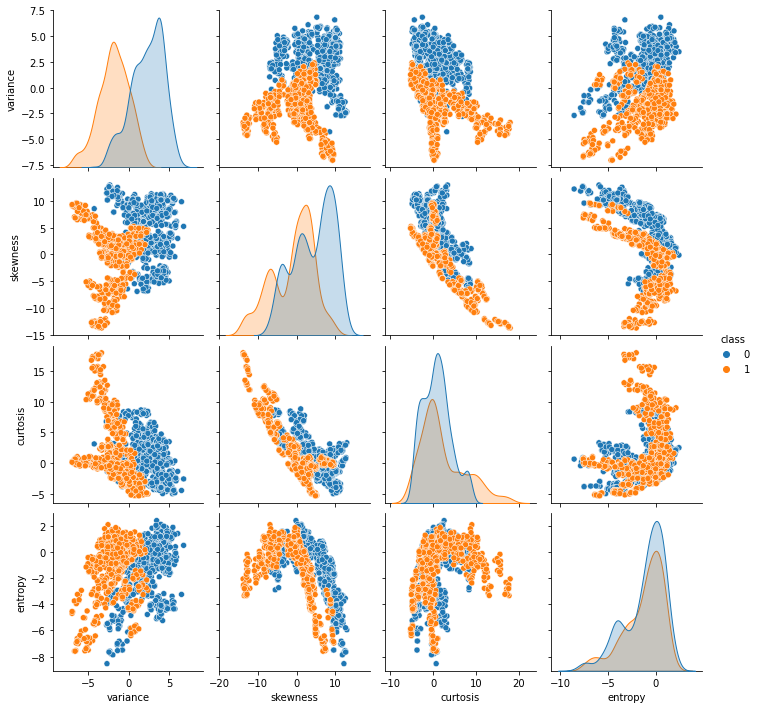

In [11]:
data = df.toPandas()
sns.pairplot(data=data,hue='class')

**There are clear separations shown, especially for pairs of features having 'variance'. The curtosis-entropy scatterplot exhibits the lowest separation**

**Let's perform a PCA analysis to bring down the features to two and plot them. Before that we have to create a single vector of features.**

In [12]:
#displaying the dataframe
df.show(3)

+--------+--------+--------+--------+-----+
|variance|skewness|curtosis| entropy|class|
+--------+--------+--------+--------+-----+
|  3.6216|  8.6661| -2.8073|-0.44699|    0|
|  4.5459|  8.1674| -2.4586| -1.4621|    0|
|   3.866| -2.6383|  1.9242| 0.10645|    0|
+--------+--------+--------+--------+-----+
only showing top 3 rows



**Let's create the Feature column using VectorAssembler**

In [13]:
#Import VectorAssembler
from pyspark.ml.feature import VectorAssembler

In [14]:
#'cols' is the list of feature names that we have
print(cols)

['variance', 'skewness', 'curtosis', 'entropy']


In [15]:
VecAssembler = VectorAssembler(inputCols=cols,outputCol="features")
#A demo of the output of vector assembler. Later we will assemble all feature transformations in a single pipeline
VecAssembler.transform(df).select("features","class").show(3)

+--------------------+-----+
|            features|class|
+--------------------+-----+
|[3.6216,8.6661,-2...|    0|
|[4.5459,8.1674,-2...|    0|
|[3.866,-2.6383,1....|    0|
+--------------------+-----+
only showing top 3 rows



**Note that we have a features and a class column now**<br>
**Let's use the randomSplit method to split the dataframe to train and test sets**

In [16]:
#let's choose 0.8 as the training split length, because we have only a few rows of data
train,test = df.randomSplit([0.8,0.2])

**Earlier we saw in the KDE graphs that the features were nearly following a normal distribution. Hence let' use a StandardScaler to scale the features**

In [17]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

In [18]:
#specify input col and output col and fit the scaler
scaler = StandardScaler(inputCol="features",outputCol="features_scaled")

#transform the datasets using a pipeline
feature_pipe = Pipeline(stages=[VecAssembler,scaler]).fit(train)
train = feature_pipe.transform(train)
test = feature_pipe.transform(test)

**Let's have a look at the scaled features**

In [19]:
train.select("features","features_scaled").show(3)

+--------------------+--------------------+
|            features|     features_scaled|
+--------------------+--------------------+
|[-7.0421,9.2,0.25...|[-2.4907053744201...|
|[-7.0364,9.2931,0...|[-2.4886893535408...|
|[-6.9599,8.9931,0...|[-2.4616322312132...|
+--------------------+--------------------+
only showing top 3 rows



**Now that we are ready with the feature vectors, let's perform the PCA decomposition**

In [20]:
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array

In [21]:
# PCA decmposition to 2 features
pca = PCA(k=3,inputCol="features",outputCol="pca").fit(train)
data = pca.transform(train).select("pca","class")
data.show(3)

+--------------------+-----+
|                 pca|class|
+--------------------+-----+
|[-6.9801755754922...|    1|
|[-7.0874738779396...|    1|
|[-6.8309161047921...|    1|
+--------------------+-----+
only showing top 3 rows



**Now the vectors in 'pca' column has to be split to two to plot it**

In [22]:
data = data.withColumn("pca",vector_to_array("pca")).select(f.col("class"),f.col("pca")[0],f.col("pca")[1],f.col("pca")[2])
data.show(3)

+-----+------------------+-------------------+-------------------+
|class|            pca[0]|             pca[1]|             pca[2]|
+-----+------------------+-------------------+-------------------+
|    1|-6.980175575492249|  -10.2829523824377|-0.9814169236067599|
|    1|-7.087473877939664|-10.211772852101056|-0.9543131837844705|
|    1|-6.830916104792128| -10.09826432503153|-0.8970956197572494|
+-----+------------------+-------------------+-------------------+
only showing top 3 rows



**Let's create a 3D Scatter plot**

In [23]:
data = data.toPandas()

In [24]:
#plotting
fig = px.scatter_3d(data, x='pca[0]', y='pca[1]', z='pca[2]',color='class',title="3D Scatterplot of PCA Features",color_continuous_scale=px.colors.sequential.Viridis)
fig.update(layout_coloraxis_showscale=False)
fig.show()

**Using PCA, we tried to reduce the number of features to 3 from 4, so that they can be visualized. As you can see, there is an excellent separation between both the classes. Let's use Logistic Classifier or Support Vector Classifier for making the model**

#### Training - Logistic Regression

In [25]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [26]:
lr = LogisticRegression(featuresCol="features",labelCol="class",predictionCol='prediction_lr')
params = ParamGridBuilder().addGrid(lr.maxIter,[50,75,100,150,200]).addGrid(lr.regParam,[0,0.0001,0.001,0.01,0.1,0.5]).build()

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction_lr',labelCol='class',metricName='f1')
CValidator = CrossValidator(estimator=lr,estimatorParamMaps=params,evaluator=evaluator,numFolds=5)
CValidator_lr = CValidator.fit(train)

#predictions on test data
predictions_lr= CValidator_lr.transform(test).select('prediction_lr','class')
predictions_lr.show(3)

+-------------+-----+
|prediction_lr|class|
+-------------+-----+
|          1.0|    1|
|          1.0|    1|
|          1.0|    1|
+-------------+-----+
only showing top 3 rows



**'class' is the original label, 'prediciton' is the predicted label and 'features_scaled' represent the scaled features**

**Let's plot the ROC curve and print the area under it**

Area under the ROC curve: 0.9998
F1 Score: 0.9924
Accuracy: 0.9924


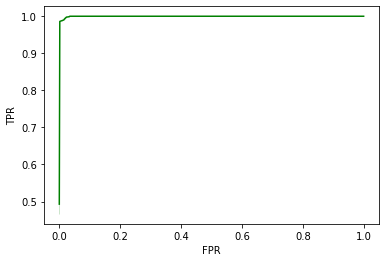

In [27]:
data = CValidator_lr.bestModel.summary.roc.toPandas()
sns.lineplot(data=data,x='FPR',y='TPR',color='green')
print("Area under the ROC curve:",format(CValidator_lr.bestModel.summary.areaUnderROC,'.4f'))
print("F1 Score:",format(evaluator.evaluate(predictions_lr),'.4f'))
evaluator.setMetricName('accuracy')
print("Accuracy:",format(evaluator.evaluate(predictions_lr),'.4f'))

**Wow! we have a nice score!**

#### Training - Support Vector Classifier

In [28]:
from pyspark.ml.classification import LinearSVC

In [29]:
svc = LinearSVC(featuresCol='features_scaled',labelCol='class',predictionCol='prediction_svc')
params = ParamGridBuilder().addGrid(svc.maxIter,[50,100,200]).addGrid(svc.regParam,[0,0.001,1]).build()
evaluator.setPredictionCol('prediction_svc')
evaluator.setMetricName('f1')

CValidator_svc = CrossValidator(estimator=svc,estimatorParamMaps=params,evaluator=evaluator).fit(train)

In [30]:
predictions_svc = CValidator_svc.transform(test).select("prediction_svc","class")

In [31]:
print("f1 Score",format(evaluator.evaluate(predictions_svc),'.4f'))
evaluator.setMetricName('accuracy')
print("Accuracy score: ",format(evaluator.evaluate(predictions_svc),'.4f'))

f1 Score 1.0000
Accuracy score:  1.0000


**Saving the model and feature pipeline**

**Let's save the SVC model**

In [32]:
#Save feature pipe

feature_pipe.save('feature_pipe')

#Save the model

CValidator_svc.bestModel.save('bank_note_model_svc')

## Deployment using StreamLit Library

#### This is an example code for deployment. Please try it on a local machine.
The following code can be saved, say as deploy.py and run as "streamlit run deploy.py"

In [33]:
!pip -q install streamlit

In [34]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LinearSVCModel
from pyspark.ml.pipeline import PipelineModel
import streamlit as st

In [35]:
#Load feature_pipe and model

feature_pipe = PipelineModel.load('feature_pipe')
model = LinearSVCModel.load('bank_note_model_svc')
spark = SparkSession.builder.master('local').appName('deployPyspark').getOrCreate()

def predict(variance,skewness,curtosis,entropy,spark):
    schema = "variance FLOAT, skewness FLOAT, curtosis FLOAT, entropy FLOAT"
    data = spark.createDataFrame([[variance,skewness,curtosis,entropy]],schema=schema)
    data = feature_pipe.transform(data)
    prediction = model.transform(data).select("prediction_svc").collect()[0][0]
    return "Fake Note" if(prediction) else "Authentic Note"
    
def noteAuth():
    st.title("Bank Note Authentication")
    st.markdown("Application for predicting the authenticity of Bank Notes")

    variance = float(st.text_input("Variance", 3.6216))
    skewness = float(st.text_input("Skewness",8.6661))
    curtosis = float(st.text_input("Curtosis",-2.8073))
    entropy = float(st.text_input("Entropy",-0.44699))

    if(st.button("Predict")):
        result = predict(variance,skewness,curtosis,entropy,spark)
        st.success(f"Prediction: {result}")

if __name__ == '__main__':
    noteAuth()

2021-06-02 20:19:17.880 WARNING root: 
  command:

    streamlit run /opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py [ARGUMENTS]


## Thank You